# XAI in deep learning-based image analysis 

## Part 2: Applying Grad-CAM

In the second part of this tutorial we are going to look at Grad-CAM, a gradient-based pixel attribution method for  understanding where a model looks to for making a classification decision on an image. We will again be usign the pre-trained ResNet-50 and play arouond with various images.

In [1]:
# Installing the necessary packages

import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import resnet50
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
%matplotlib inline 
import numpy as np
import cv2 as cv
from torchvision import models, transforms
import torch

### The input image: loading and preparing for the model

In the below step, we: 
* Load the image
* Convert the image to RGB channel
* Transform the image -
  * Convert to PIL format
  * Resize to lower resolution
  * Convert to tensor dtype
  * Normalize the pixel values
* Unsqueeze the image to add a batch dimension
* Define a dataloader to load single image

In [26]:
# define the transforms ( here we are using the ImageNet transformations)
transform = transforms.Compose([transforms.ToPILImage(),
                                transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

def read_img(path_to_img):
    img = cv.imread(path_to_img) # Insert the path to image.
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return img

def transfor_img(img, transform):
    arr_img = np.array(img)
    # apply the transforms
    trans_img = transform(arr_img)
    # unsqueeze to add a batch dimension
    trans_img = trans_img.unsqueeze(0)
    return trans_img

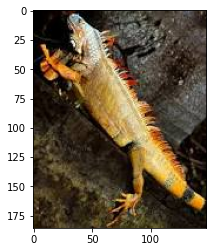

Transformed image size:  torch.Size([1, 3, 224, 224])


In [2]:
# read and visualize an image
path_to_img = 'images/Iguana.jpeg'
img = read_img(path_to_img)
plt.imshow(img)
plt.show()

# next transform it so it is ready to be given to the model
trans_img = transfor_img(img, transform)
print('Transformed image size: ', trans_img.size())

# # define the dataloader to load that single image
#dataloader = data.DataLoader(dataset=trans_img, shuffle=False, batch_size=1)

### Defining a GradCam model

* We are using hooks to get the activation maps and the gradients from the desired layer and tensor, respectively. 
* For this tutorial, we are going to take the activation maps from layer4 of ResNet50 and gradients with respect to the output tensor of the same.

In [3]:
# GradCamModel class with a ResNet pretrained model
class GradCamModel(nn.Module):
    def __init__(self):
        super(GradCamModel, self).__init__()
        
        # define the resnet152
        self.resnet = resnet50(pretrained=True)
        
        # isolate the feature blocks
        self.features = nn.Sequential(self.resnet.conv1,
                                      self.resnet.bn1,
                                      nn.ReLU(),
                                      nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
                                      self.resnet.layer1, 
                                      self.resnet.layer2, 
                                      self.resnet.layer3, 
                                      self.resnet.layer4)
        
        # average pooling layer
        self.avgpool = self.resnet.avgpool
        
        # classifier
        self.classifier = self.resnet.fc
        
        # gradient placeholder
        self.gradient = None
    
    # hook for the gradients
    def activations_hook(self, grad):
        self.gradient = grad
    
    def get_gradient(self):
        return self.gradient
    
    def get_activations(self, x):
        return self.features(x)
    
    def forward(self, x):
        
        # extract the features
        x = self.features(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # complete the forward pass
        x = self.avgpool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        
        return x



First, we make the forward pass through the network with the image and see what the ResNet-50 predicts. 

In [47]:
# init the GradCamModel
gcmodel = GradCamModel()

# set the evaluation mode
_ = gcmodel.eval()

# get the image
#img = next(iter(dataloader))

# forward pass
out = gcmodel(trans_img) # img)
pred = out.argmax(dim=1)

print('Classification result:', pred.item())


Classification result: 428


Click the link to identify the class name: https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/

Now, we are going to do the back-propagation with the logit of the predicted class in the ImageNet dataset.

Grad-CAM uses the feature maps produced by the last convolutional layer of a CNN. The authors of Grad-CAM argue, “we can expect the last convolutional layers to have the best compromise between high-level semantics and detailed spatial information.”

Grad-CAM is applied to a neural network that has finished training. The weights of the neural network are fixed. We feed an image into the network to calculate the Grad-CAM heatmap for a specific image and a chosen class of interest.

### Grad-CAM Details

Let us assume $y^c$ is the score for class $c$ i.e., the output for class $c$ before the softmax.

**Step 1: Computing Gradient**

Compute the gradient of $y^c$ with respect to the feature map activation $A^k$ of a convolution layer i.e., $\frac {∂y^c}{∂A^k}$

**Step 2: Calculate Global Average Pooling ( GAP ) of the feature map.**
     
Global average pool the gradients over the width dimension (indexed by $i$) and the height dimension (indexed by $j$) to obtain neuron importance weights ${\alpha_k^c}$

  $
  {\alpha_k^c} = \frac {1}{Z} \sum_{i} \sum_{j} \frac {∂y^c}{∂A^k_{ij}}
  $

**Step 3: Calculate Final Grad-CAM Heatmap**
     
Perform a weighted combination of the feature map activations $A^k$ where the weights are the ${\alpha_k^c}$ just calculated.

  $
  L^c_{Grad-CAM} = ReLU (\sum_k {\alpha_k^c} A^k)
  $


In [48]:
def calculate_heatmap(gcmodel, img, out, c):
    # get the gradient of the output with respect to the parameters of the model
    out[:,c].backward(retain_graph=True)

    # pull the gradients out of the model
    gradients = gcmodel.get_gradient()

    # pool the gradients across the channels
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

    # get the activations of the last convolutional layer
    activations = gcmodel.get_activations(img).detach()

    # weight the channels by corresponding gradients
    for i in range(activations.size(1)):
        activations[:, i, :, :] *= pooled_gradients[i]

    # average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # relu on top of the heatmap
    heatmap = np.maximum(heatmap, 0)

    # normalize the heatmap
    heatmap /= torch.max(heatmap)
    
    return heatmap

def process_heatmap(heatmap, img):
    # convert the heatmap to be a numpy array
    heatmap = heatmap.numpy()
    # resize to image size
    heatmap = cv.resize(heatmap, (img.shape[1], img.shape[0]))
    # normalize to [0, 255] range and convert to unsigned int
    heatmap = np.uint8(255 * heatmap)
    return heatmap

### Implementation:

Call calculate_heatmap to get the Res-Net GradCAM output for class 'iguana'

Next, process the result for visualisation and visualise it along with original image and the Grad-CAM heat-map projected onto the original image.

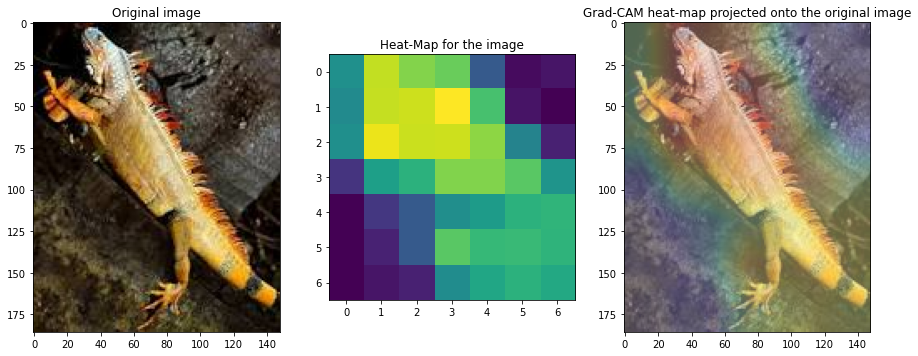

In [22]:
heatmap = calculate_heatmap(gcmodel, trans_img, out, c=39)

# convert the heatmap to be a numpy array
heatmap_n = heatmap.numpy()
# resize to image size
heatmap_n = cv.resize(heatmap_n, (img.shape[1], img.shape[0]))
# normalize to [0, 255] range and convert to unsigned int
heatmap_n = np.uint8(255 * heatmap_n)

plt.figure(figsize=(15, 15))
plt.subplot(131)
plt.imshow(img)
plt.title('Original image')
plt.subplot(132)
plt.imshow(heatmap.squeeze())
plt.title('Heat-Map for the image')
plt.subplot(133)
plt.imshow(heatmap_n, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)
plt.title('Grad-CAM heat-map projected onto the original image')
plt.show()

### Now let's look at a different image

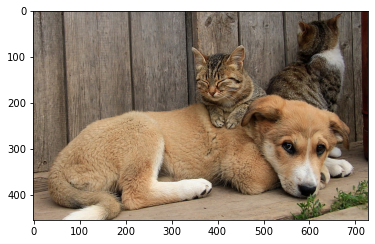

Transformed image size:  torch.Size([1, 3, 224, 224])
Classification result: 282


In [69]:
# read and visualize an image
img = read_img('images/cat_and_dog.jpg')
plt.imshow(img)
plt.show()

# next transform it so it is ready to be given to the model
trans_img = transfor_img(img, transform)
print('Transformed image size: ', trans_img.size())

# forward pass
out = gcmodel(trans_img) # img)
pred = out.argmax(dim=1)

print('Classification result:', pred.item())

What is the model predicting? Let's look at the top two predictions and try and understand each!

In [70]:
pred_sort= torch.argsort(out)
top_ten = pred_sort[0,-10:]
print('Top ten classes predicted: ', top_ten)

Top two classes predicted:  tensor([269, 539, 263, 230, 264, 285, 273, 231, 281, 282])


Take a moment to identify the class names.

Now let's use GradCAM to try and understand where the model is focusing for specific probabilities

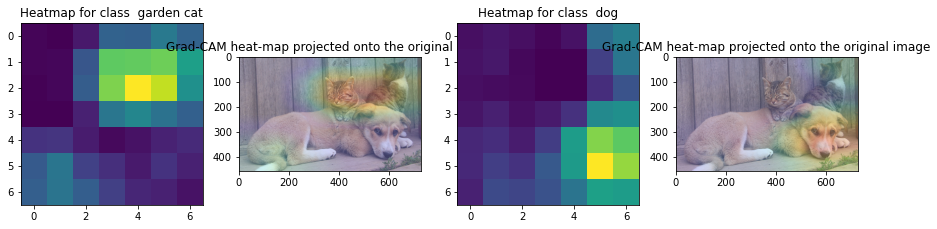

In [71]:
heatmap1 = calculate_heatmap(gcmodel, trans_img, out, c=282)
heatmap2 = calculate_heatmap(gcmodel, trans_img, out, c=231)

heatmap1_n = process_heatmap(heatmap1, img)
heatmap2_n = process_heatmap(heatmap2, img)

plt.figure(figsize=(15, 15))
plt.subplot(141)
plt.imshow(heatmap1.squeeze())
plt.title('Heatmap for class  garden cat')
plt.subplot(142)
plt.imshow(heatmap1_n, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)
plt.title('Grad-CAM cat projection)
plt.subplot(143)
plt.imshow(heatmap2.squeeze())
plt.title('Heatmap for class  dog')
plt.subplot(144)
plt.imshow(heatmap2_n, cmap='jet', alpha=0.4)
plt.imshow(img, alpha=0.6)
plt.title('Grad-CAM dog projection')
plt.show()

What did we learn today? Take this short **questionnaire**[add link] to revise what you have learned in our session today!

## Homework

* Look at the top-10 classes of the model - can you see a pattern?
* Can you implement the occlusion technique (see Grad-CAM paper)on the last image and see what you get?

## Further reading:

Here is the original GradCAM paper: https://arxiv.org/pdf/1610.02391.pdf

This tutorial was based on: https://medium.com/@stepanulyanin/grad-cam-for-resnet152-network-784a1d65f3